In [184]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature import settings
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit.utils import algorithm_globals
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from hierarqcal import Qinit, Qcycle, Qunitary
from qiskit import QuantumRegister,QuantumCircuit
from functools import partial, reduce
import pennylane as qml
import sympy

seed = 170
algorithm_globals.random_seed = seed
settings.use_pauli_sum_op = False
np.random.seed(seed)

In [185]:
driver = PySCFDriver(
    atom="H -0.0254 0.0000 0.0000; H 0.7174 0.0000 0.0000",
    basis="631g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()
mapper = ParityMapper()
qubit_op = mapper.map(problem.hamiltonian.second_q_op())

In [186]:
qubit_op.num_qubits, len(qubit_op)

(8, 185)

In [187]:
problem.num_spatial_orbitals

4

In [188]:
num_electrons = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals
num_spatial_orbitals = 2

transformer = transformer = ActiveSpaceTransformer(
        num_electrons=num_electrons, # Number of electrons in our active space
        num_spatial_orbitals=num_spatial_orbitals, # Number of orbitals in our active space
        active_orbitals=None # May be useful
    )

# Now you can get the reduced electronic structure problem
problem_reduced = transformer.transform(problem)

qubit_op_reduced = mapper.map(problem_reduced.hamiltonian.second_q_op())

In [189]:
num_qubits = qubit_op_reduced.num_qubits
num_qubits, len(qubit_op_reduced)

(4, 15)

In [190]:
numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(mapper, numpy_solver)
res_actual = calc.solve(problem)

In [191]:
print(res_actual)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.864099028482
  - computed part:      -1.864099028482
~ Nuclear repulsion energy (Hartree): 0.712408738449
> Total ground state energy (Hartree): -1.151690290033
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.30769048  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [1.307690478199  0.0  0.0]
    - computed part:      [1.307690478199  0.0  0.0]
  > Dipole moment (a.u.): [0.000000001801  0.0  0.0]  Total: 0.000000001801
                 (debye): [0.000000004578  0.0  0.0]  Total: 0.000000004578
 


In [224]:
exact_energy = res_actual.eigenvalues[0]
exact_energy

-1.864099028482359

In [225]:
num_particles = problem.num_particles

hf_state = HartreeFock(num_spatial_orbitals=num_spatial_orbitals,
                       num_particles=num_particles,
                       qubit_mapper=mapper)

In [226]:
hf_state.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────

In [227]:
# Generate single and double excitations
electrons = sum(problem.num_particles)
num_spin_orbitals = 2*num_spatial_orbitals

singles, doubles = qml.qchem.excitations(electrons, num_spin_orbitals)

# Map excitations to the wires the UCCSD circuit will act on
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

print("s_wires:", s_wires)
print("d_wires:", d_wires)

s_wires: [[0, 1, 2], [1, 2, 3]]
d_wires: [[[0, 1], [2, 3]]]


In [228]:
def FermionicSingleExcitation(n_qubits, symbol_prefix='x'):
    # TODO: Use Symbol prefix. It is needed for the circuit to be logically correct
    
    l = lambda order='sorted': Qcycle(1,
                                      1,
                                      0,
                                      mapping=Qunitary("CNOT()^01"),
                                      boundary="open",
                                      edge_order=range(n_qubits, 1, -1)
                                      if order == 'rev' else range(
                                          1, n_qubits))

    single_qg = lambda gate, q: Qcycle(
        1, n_qubits, q, mapping=Qunitary(f"{gate}^0"), boundary="open")

    r = partial(single_qg, q=0)
    p = partial(single_qg, q=n_qubits - 1)

    hierq = Qinit(n_qubits) + r('Rx(x)') + p("h()") + l() + p('Rz(x)') + l(
        'rev') + r('Rx(x)') + p('h()')
    hierq += Qinit(n_qubits) + p('Rx(x)') + r("h()") + l() + p('Rz(x)') + l(
        'rev') + p('Rx(x)') + r('h()')
    
    circuit = hierq(backend="qiskit", barriers=False)
    rx_n = [0, 3]
    rx_p = [2, 5]
    rz_n = [4]
    rz_p = [1]

    params = {}
    for param in circuit.parameters:
        idx = int(param.name.split('_')[-1])
        if idx in rx_n:
            params[param] = -np.pi / 2
        elif idx in rx_p:
            params[param] = np.pi / 2
        elif idx in rz_n:
            params[param] = -param / 2
        elif idx in rz_p:
            params[param] = param / 2

    circuit = circuit.assign_parameters(params)
    return circuit

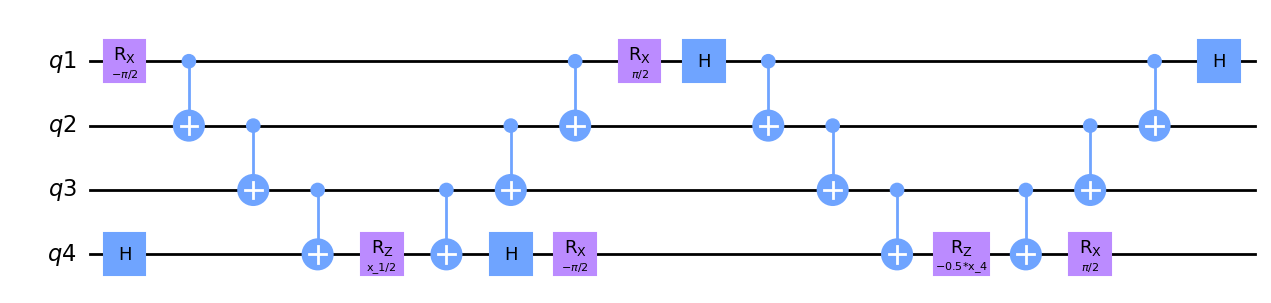

In [229]:
circuit = FermionicSingleExcitation(num_qubits)
circuit.draw("mpl")

In [230]:
def FermionicDoubleExcitation(n_qubits, qubits1, qubits2, symbol_prefix='x'):
    # TODO: Use Symbol prefix. It is needed for the circuit to be logically correct

    single_qg = lambda gate, q: Qcycle(
        1, n_qubits, q, mapping=Qunitary(f"{gate}^0"), boundary="open")

    jump = [qubits1[-1], qubits2[0]]
    jump_stride = qubits2[0] - qubits1[-1]

    s = partial(single_qg, q=qubits1[0])
    r = partial(single_qg, q=qubits1[-1])
    q = partial(single_qg, q=qubits2[0])
    p = partial(single_qg, q=qubits2[-1])
    sqg = [s, r, q, p]

    def cnot_ladder(bits, symbols=None, circuit=None, **kwargs):
        order = kwargs['order']
        qubits = [QuantumRegister(1, bit) for bit in bits]
        iterator = range(len(qubits) - 2, -1, -1) if order == 'rev' else range(len(qubits) - 1)
        for i in iterator:
            circuit.cnot(qubits[i], qubits[i + 1])
        return circuit

    l = lambda wires, stride=n_qubits, order='sorted': Qcycle(
        stride,
        n_qubits,
        wires[0],
        mapping=Qunitary(partial(cnot_ladder, order=order), 0, len(wires)),
        boundary="open",
        edge_order=[3, 2, 1])

    cx = Qinit(n_qubits) + l(qubits1) + l(jump, jump_stride) + l(qubits2) 
    inv_cx = Qinit(n_qubits) + l(qubits2, order='rev') + l(jump, jump_stride) + l(qubits1, order='rev')

    h_set = lambda pos: reduce(lambda a, b: a + b, [
        sqg[i]('Rx(x)') if val == '0' else sqg[i]('h()')
        for i, val in enumerate(pos)
    ])

    h_locations = [
        '1101', '0100', '1000', '1110', '0111', '1011', '0001', '0010'
    ]

    layers = [
        Qinit(n_qubits) + h_set(location) + cx + p('Rz(x)') + inv_cx + h_set(location)
        for location in h_locations
    ]

    hierq = Qinit(n_qubits) + reduce(lambda a, b: a + b, layers)
    circuit = hierq(backend="qiskit", barriers=False)
    
    rx_n = [0,3,4,5,10,11,12,17,20,23,26,27,28,33,34,35]
    rx_p = [2,7,8,9,14,15,16,19,22,25,30,31,32,37,38,39]
    rz_n = [1,6,13,18]
    rz_p = [21,24,29,36]

    params = {}
    for param in circuit.parameters:
        idx = int(param.name.split('_')[-1])
        if idx in rx_n:
            params[param] = -np.pi/2
        elif idx in rx_p:
            params[param] = np.pi/2
        elif idx in rz_n:
            params[param] = -param / 8
        elif idx in rz_p:
            params[param] = param / 8
    
    circuit = circuit.assign_parameters(params)
    return circuit

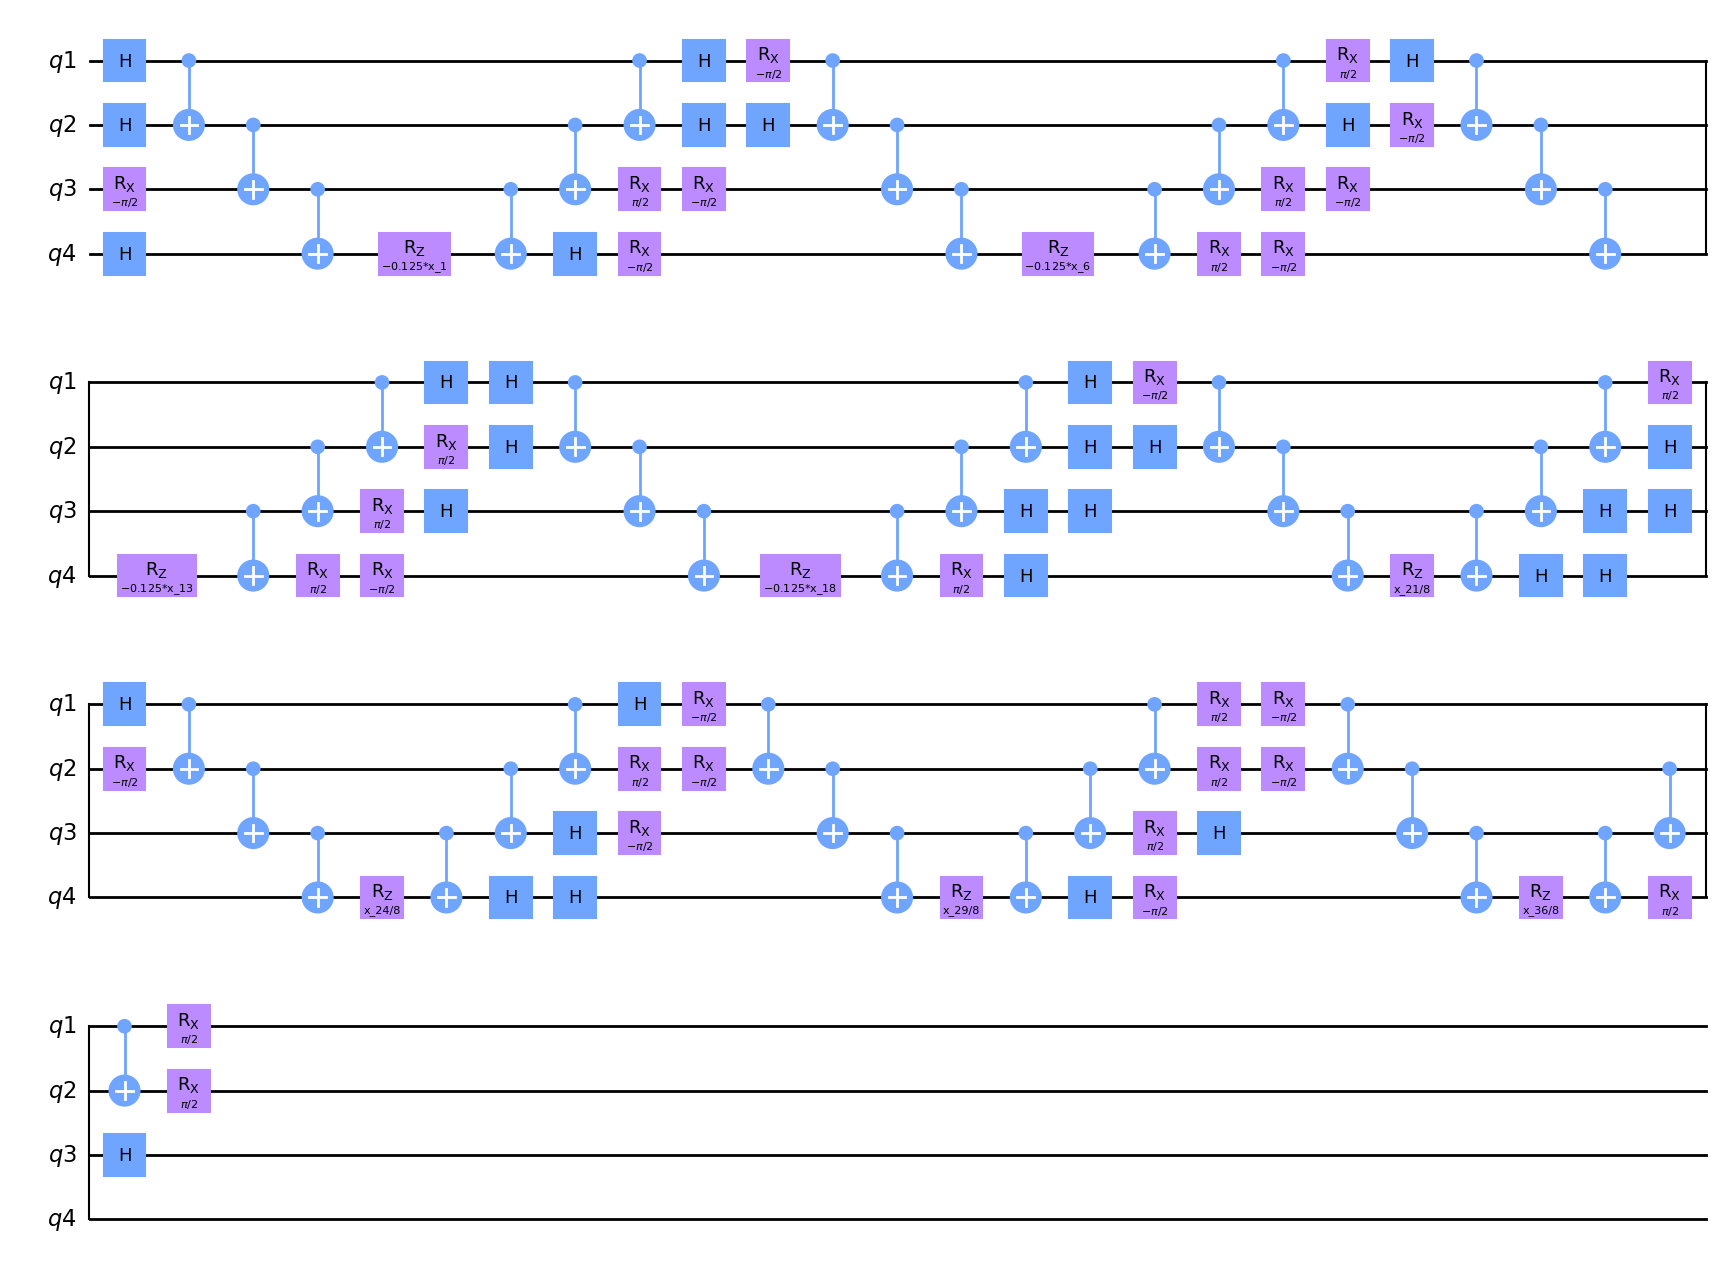

In [231]:
circuit = FermionicDoubleExcitation(num_qubits, d_wires[0][0], d_wires[0][1])
circuit.draw("mpl")

In [232]:
def UCCSD(n_qubits, s_qubits, d_qubits, init_state=None):
    circuit = QuantumCircuit(n_qubits)
    
    if init_state is not None:
        circuit.compose(init_state, inplace=True)
        circuit.barrier()
    
    for i, (qubits1, qubits2) in enumerate(d_wires):
        circuit.compose(FermionicDoubleExcitation(num_qubits, d_wires[0][0], d_wires[0][1]), inplace=True)
        circuit.barrier()
        
#     for j, s_qubits in enumerate(s_wires):
#         circuit.compose(FermionicSingleExcitation(num_qubits, s_qubits), inplace=True)
#         circuit.barrier()

    return circuit

In [233]:
ansatz = UCCSD(num_qubits, s_wires, d_wires, hf_state)

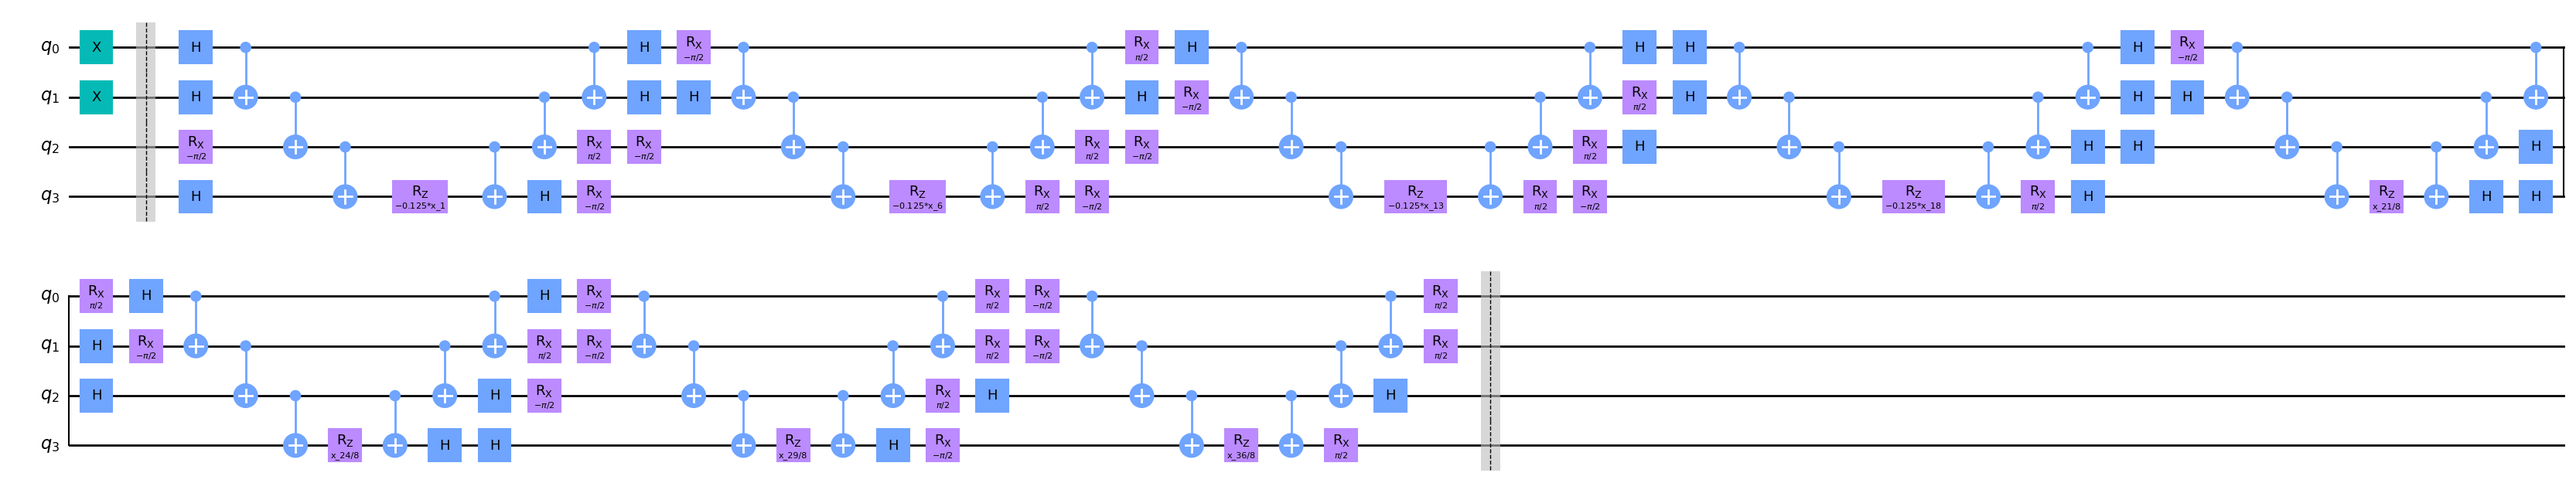

In [234]:
ansatz.draw('mpl', fold=50)

In [235]:
optimizer = COBYLA(maxiter=100)
estimator = Estimator()

In [236]:
intermediate_info = []

def callback(eval_count, parameters, value, std):
    intermediate_info.append(value)
    clear_output(wait=True)
    plt.plot(intermediate_info, color='purple', lw=2, label=f'Simulated VQE {np.round(value,4)}')
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=exact_energy,color="tab:red",ls="--", lw=2,label="Target: "+str(np.round(exact_energy,4)))
    plt.legend()
    plt.grid()
    plt.show()

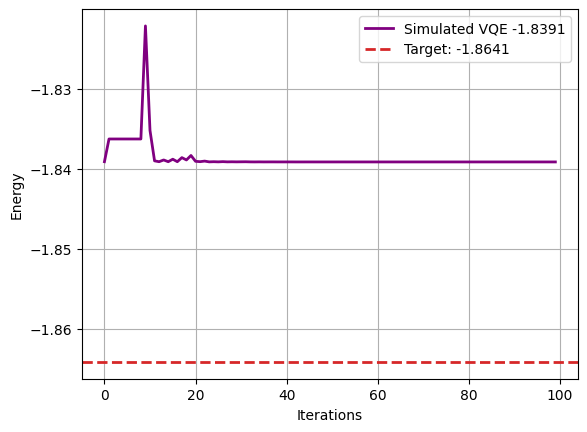

In [237]:
vqe = VQE(estimator, 
          ansatz, 
          optimizer, 
          callback=callback)

result = vqe.compute_minimum_eigenvalue(operator=qubit_op_reduced)

In [238]:
interpreted_result = problem_reduced.interpret(result)
print(interpreted_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.83911868052
  - computed part:      -1.83911868052
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.712408738449
> Total ground state energy (Hartree): -1.126709942071
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.30769048  0.0  0.0]
 


In [239]:
def rel_err(target, measured):
    return abs((target - measured) / target)

In [240]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(res_actual.total_energies[0], interpreted_result.total_energies[0])

print(f'Expected ground state energy: {res_actual.total_energies[0]:.12f}')
print(f'Computed ground state energy: {interpreted_result.total_energies[0]:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -1.151690290033
Computed ground state energy: -1.126709942071
Relative error: 0.021690161130
